In [1]:
using Pkg
Pkg.activate("/home/claudio/postdoc/ACE.jl/Project.toml")

using JuLIP, ACE, IPFitting, LinearAlgebra, Statistics, ScikitLearn, Random, Plots
using ACE: alloc_B, alloc_temp, evaluate!,alloc_dB, alloc_temp_d, evaluate_d!
using NeighbourLists: maxneigs
using JuLIP: sites, neighbourlist, cutoff, JVec, AbstractAtoms
using JuLIP.Potentials: neigsz!

@sk_import linear_model: Ridge
using ScikitLearn.CrossValidation: train_test_split

 Activating environment at `~/postdoc/ACE.jl/Project.toml`
┌ Info: Precompiling IPFitting [3002bd4c-79e4-52ce-b924-91256dde4e52]
└ @ Base loading.jl:1278
┌ Info: Skipping precompilation since __precompile__(false). Importing IPFitting [3002bd4c-79e4-52ce-b924-91256dde4e52].
└ @ Base loading.jl:1034
┌ Info: Precompiling ASE [51974c44-a7ed-5088-b8be-3e78c8ba416c]
└ @ Base loading.jl:1278
┌ Info: Skipping precompilation since __precompile__(false). Importing ASE [51974c44-a7ed-5088-b8be-3e78c8ba416c].
└ @ Base loading.jl:1034


In [39]:
function sum_descriptor(shipB, at::AbstractAtoms{T}) where {T}
   E = zeros(JuLIP.fltype(shipB), length(shipB))
   B = alloc_B(shipB)
   nlist = JuLIP.neighbourlist(at, cutoff(shipB))
   maxnR = JuLIP.maxneigs(nlist)
   tmp = alloc_temp(shipB, maxnR)
   tmpRZ = (R = zeros(JVec{T}, maxnR), Z = zeros(AtomicNumber, maxnR))
   for i = 1:length(at)
      j, R, Z = neigsz!(tmpRZ, nlist, at, i)
      fill!(B, 0)
      evaluate!(B, tmp, shipB, R, Z, at.Z[i])
      E[:] .+= B[:]
   end
   return E
end

function sum_descriptor_traj(basis, traj)
    A_all = Array{Float64, 2}(undef, length(traj), length(basis)) 
    for i in 1:length(traj)
        atoms = traj[i].at
        A_all[i, :] = sum_descriptor(basis, atoms)
    end
    return A_all
end;


function sum_d_descriptor(shipB, at::AbstractAtoms{T}) where {T}
   # precompute the neighbourlist to count the number of neighbours
   nlist = JuLIP.neighbourlist(at, cutoff(shipB); storelist=false)
   maxR = JuLIP.maxneigs(nlist)
   # allocate space accordingly
   F = zeros(JVec{T}, length(at), length(shipB))
   B = alloc_B(shipB, maxR)
   dB = alloc_dB(shipB, maxR)
   tmp = alloc_temp_d(shipB, maxR)
   tmpRZ = (R = zeros(JVec{T}, maxR), Z = zeros(AtomicNumber, maxR))
   return sum_d_descriptor_inner!(shipB, at, nlist, F, B, dB, tmp, tmpRZ)
end

# this is a little hack to remove a type instability. It probably makes no
# difference in practise...
function sum_d_descriptor_inner!(shipB, at::AbstractAtoms{T},
                       nlist, F, B, dB, tmp, tmpRZ) where {T}
   # assemble site gradients and write into F
   for i = 1:length(at)
      j, R, Z = neigsz!(tmpRZ, nlist, at, i)
      fill!(dB, zero(JVec{T}))
      fill!(B, 0)
      evaluate_d!(B, dB, tmp, shipB, R, Z, at.Z[i])
      for a = 1:length(R)
         F[j[a], :] .-= dB[:, a]
         F[i, :] .+= dB[:, a]
      end
   end
   return [ F[:, iB] for iB = 1:length(shipB) ]
end

function sum_d_descriptor_traj(basis, traj)
    dA_all = []
    for i in 1:length(traj)
        atoms = traj[i].at
        XF = sum_d_descriptor(basis, atoms);
        XF = hcat([collect(Iterators.flatten(a)) for a in XF]...)
        push!(dA_all, XF)
    end
    return dA_all
end;

function fit_potential(XE_tr, YE_tr, XF_tr, YF_tr, alpha=1.0)
    YF_tr = hcat(YF_tr'...)'
    XF_tr = hcat(XF_tr'...)'
    X_tr = vcat(XE_tr, XF_tr)
    Y_tr = vcat(YE_tr, YF_tr);
    ridge_pred = fit!(Ridge(alpha), X_tr, Y_tr)
    return ridge_pred
end

function predict_potential(ridge_pred, XE_tst, XF_tst)
    n_struc = length(XE_tst[:, 1])
    XF_tst = hcat(XF_tst'...)'
    X_tst = vcat(XE_tst, XF_tst)
    result = predict(ridge_pred, X_tst)
    return result[1:n_struc], result[n_struc+1:end]
end

function extract_info(B, traj)
    XE = sum_descriptor_traj(B, traj);
    XF = sum_d_descriptor_traj(B, traj);

    YE = Vector{Float64}(undef, length(traj)) 
    for i in 1:length(traj)
        YE[i] = traj[i].D["E"][1]
    end

    YF = Vector{Float64}[]
    for i in 1:length(traj)
        push!(YF, traj[i].D["F"])
    end

    nat = Vector{Float64}(undef, length(traj)) 
    for i in 1:length(traj)
        nat[i] = length(traj[i])
    end
    
    return XE, YE, XF, YF, nat
    end;

In [36]:
N = 3
maxdeg = 12
rcut = 6.0
species = :Si;

In [66]:
B = rpi_basis(; species=species, N = N, r0 = 2.0,
   maxdeg = maxdeg, rcut = rcut,
   rin = rnn(:Si) * 0.6,
   constants = false);

In [67]:
traj = IPFitting.Data.read_xyz("/home/claudio/postdoc/eFF/data/data_Zuo_2020/Si/train_trajectory.xyz", 
    energy_key="DFT_PE", force_key="dft_forces", verbose=false);

┌ Info: Keys used: E => "DFT_PE", F => "dft_forces", V => "dft_virial"
└ @ IPFitting.Data /home/claudio/.julia/packages/IPFitting/Ypo4v/src/data.jl:153
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


┌─────────────┬───────┬───────┬───────┬───────┬───────┐
│ config_type │ #cfgs │ #envs │    #E │    #F │    #V │
│      String │ Int64 │ Int64 │ Int64 │ Int64 │ Int64 │
├─────────────┼───────┼───────┼───────┼───────┼───────┤
│     nothing │   214 │ 13233 │   214 │ 39699 │     0 │
├─────────────┼───────┼───────┼───────┼───────┼───────┤
│       total │   214 │ 13233 │   214 │ 39699 │     0 │
│     missing │     0 │     0 │     0 │     0 │  1926 │
└─────────────┴───────┴───────┴───────┴───────┴───────┘


In [68]:
XE, YE, XF, YF, nat = extract_info(B, traj)

XE_tr, XE_tst, YE_tr, YE_tst, XF_tr, XF_tst, YF_tr, YF_tst, nat_tr, nat_tst = train_test_split(
    XE, YE, XF, YF, nat, test_size=0.25, random_state=42);

In [69]:
rr = fit_potential(XE_tr, YE_tr, XF_tr, YF_tr, 0.1)
e_hat, f_hat = predict_potential(rr, XE_tst, XF_tst);

RMSE Energy [meV/atom]:  8.211298555937411

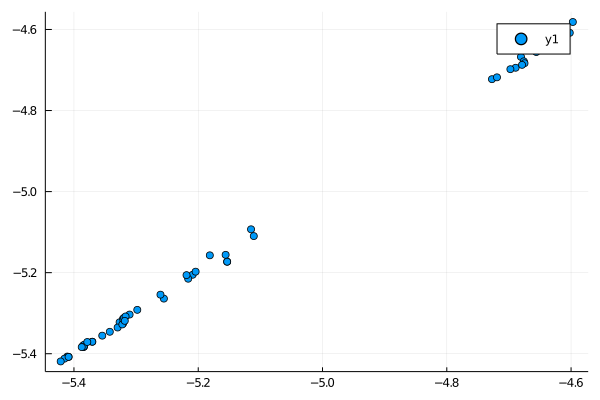

In [72]:
rmse_e = mean((YE_tst./nat_tst .-  e_hat./nat_tst).^2).^0.5
print("RMSE Energy [meV/atom]:  ", 1000*rmse_e)
plot(YE_tst./nat_tst, e_hat./nat_tst, seriestype = :scatter)

RMSE Forces [eV/A]:  0.1229569230343308

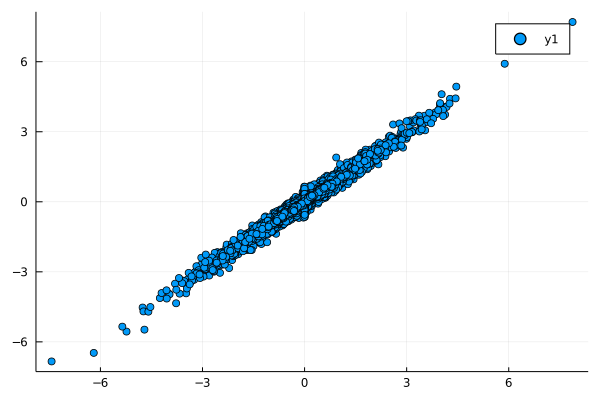

In [71]:
rmse_f = mean((hcat(YF_tst'...)' .-  f_hat).^2).^0.5
print("RMSE Forces [eV/A]:  ", rmse_f)
plot(hcat(YF_tst'...)', f_hat, seriestype = :scatter)